In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

from copy import deepcopy

!pip install nlopt
import nlopt

from utils.models import DummyNetwork, TeacherNetwork
from utils.datasets import construct_toy_dataset
from utils.jax_helpers import jax_loss, jax_grad, jax_evals

import jax.numpy as jnp

# Dataset

In [23]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

dataset, labels = construct_toy_dataset()

In [24]:
data = pd.read_csv('experiments_data_student_5.csv', float_precision='round_trip')
len(data)

1000

In [25]:
sample_point = data.loc[267]
print(sample_point['loss'])
sample_point['gradient norm']

8.099134926152017e-05


8.919783839937883e-11

# Helper for extracting the weights from one data point.

In [26]:
def extract_weights(data_point):
  incoming_weights_x = []
  incoming_weights_y = []
  outgoing_weights = []

  for i in range(0, int(data_point['student size'])):
    neuron_traj_x = np.fromstring(data_point['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_point['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    incoming_weights_x.append(neuron_traj_x[-1])
    incoming_weights_y.append(neuron_traj_y[-1])
    neuron_traj_out = np.fromstring(data_point['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    outgoing_weights.append(neuron_traj_out[-1])

  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [27]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)
w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                 [incoming_weights_x[1], incoming_weights_y[1]],
                 [incoming_weights_x[2], incoming_weights_y[2]],
                 [incoming_weights_x[3], incoming_weights_y[3]],
                 [incoming_weights_x[4], incoming_weights_y[4]]])

w_out = np.array([outgoing_weights])

[0.3195520888581026, -0.7345505945267169, 0.6661511292864194, 0.9814681204937439, -0.7345489746807867]
[-0.039923840043947265, 0.8039611632286122, -1.0126555858766897, 0.6580154296957467, 0.8039597629685223]
[0.6155369494601918, 0.1433407208654592, -0.34013755116068917, 0.39531142257453944, -0.8140491475825246]


In [28]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

# Plotting of the neuron point

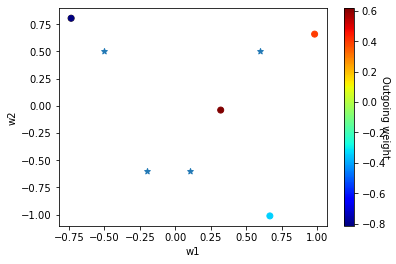

In [29]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar().set_label('Outgoing weight',rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

# JAX helpers for finding an escape route

Loss of the network computed in JAX.

In [30]:
print(jax_loss(jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student))))

8.09913492615202e-05


## Eigenvalues in JAX

In [31]:
evals, evectors = jax_evals(jnp.append(w_in.reshape(D_in * H_student), w_out.reshape(H_student)))

print(evals[:3])
smallest_evector = evectors[:, jnp.argmin(evals)]
print(smallest_evector)

[-1.6417970902055648e-16  7.4283561696734014e-07  3.9821019714869349e-05]
[ 6.8233814535156711e-14 -2.4255424587878312e-13 -4.3648990811362951e-06
  3.9424872501587120e-06  4.2837739084817291e-13 -3.1526702929054275e-13
  1.3018870105481578e-14  4.2634011795963564e-14  6.3845773678127683e-07
 -5.2209864474376301e-07  5.1909858307729202e-13 -7.0710678117406178e-01
 -5.5260729376171741e-13  5.7654013109122884e-15  7.0710678117408965e-01]


## Perturbation (based on JAX evectors) in the dir of smallest evector

In [32]:
old_loss = jax_loss(jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student)))

perturb_lower_bound = -8.0
perturb_upper_bound = 8.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []
perturb_grads = []

weights = jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  perturb_grads.append(jnp.linalg.norm(jax_grad(new_weights)))
  
  evals, _ = jax_evals(new_weights)

  perturb_evals.append(min(evals))
  perturb_losses.append(jax_loss(new_weights))

## Plot the result of perturbation

Text(0, 0.5, 'gradient norm')

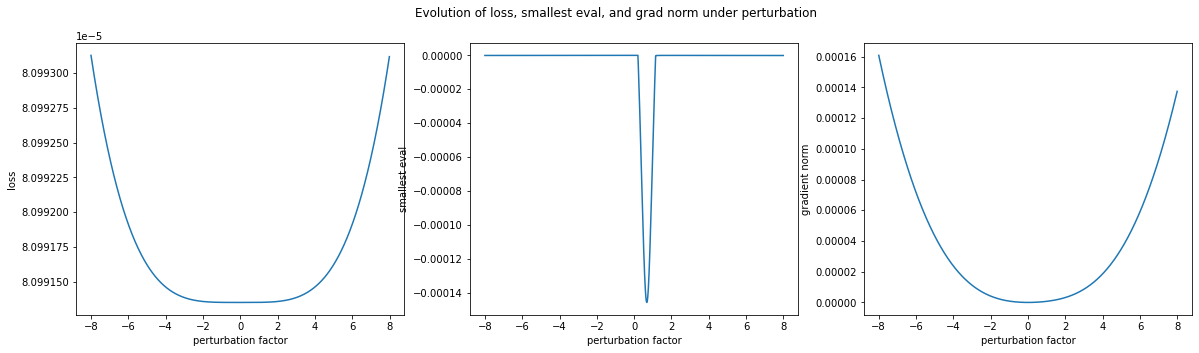

In [33]:
fig_escape, axs = plt.subplots(1, 3)
fig_escape.set_size_inches(20, 5)
fig_escape.suptitle('Evolution of loss, smallest eval, and grad norm under perturbation')

axs[0].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_losses)
axs[0].ticklabel_format(useOffset=False)
axs[0].set_xlabel('perturbation factor')
axs[0].set_ylabel('loss')

axs[1].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_evals)
axs[1].set_xlabel('perturbation factor')
axs[1].set_ylabel('smallest eval')

axs[2].plot(np.arange(perturb_lower_bound, perturb_upper_bound, perturb_step), perturb_grads)
axs[2].set_xlabel('perturbation factor')
axs[2].set_ylabel('gradient norm')

## Perturbation in the direction of the smallest evectors

In [34]:
from collections import deque

def run_perturbation_algo(start_weights,
                          perturb_losses,
                          eps = 1e-1):
  q = deque()
  q.append((start_weights, 0))

  while len(q) > 0:
    current_weights, current_dist = q.popleft()
    perturb_losses.append(jax_loss(current_weights))

    evals, evectors = jax_evals(current_weights)

    for idx, eval in enumerate(evals):
      if eval >= 1e-10:
        continue

      if eval <= -1e-8:
        print(eval)

      current_evector = evectors[:, idx]

      new_weights = current_weights + eps * current_evector
      new_dist = round(np.linalg.norm(new_weights - start_weights) / eps)

      if jnp.linalg.norm(jax_grad(new_weights)) <= 1e-9 and \
         new_dist > current_dist:
        print(current_evector)
        q.append((new_weights, new_dist))

      new_weights = current_weights - eps * current_evector
      new_dist = round(np.linalg.norm(new_weights - start_weights) / eps)

      if jnp.linalg.norm(jax_grad(new_weights)) <= 1e-9 and \
         new_dist > current_dist:
        q.append((new_weights, new_dist))

perturb_losses = []
eps = 1e-1
while len(perturb_losses) < 50 and eps >= 1e-12:
  perturb_losses = []
  run_perturbation_algo(weights, perturb_losses, eps)
  eps /= 1.2
  if eps < 1e-12:
    break

print(len(perturb_losses), min(perturb_losses))

[ 6.8233814535156711e-14 -2.4255424587878312e-13 -4.3648990811362951e-06
  3.9424872501587120e-06  4.2837739084817291e-13 -3.1526702929054275e-13
  1.3018870105481578e-14  4.2634011795963564e-14  6.3845773678127683e-07
 -5.2209864474376301e-07  5.1909858307729202e-13 -7.0710678117406178e-01
 -5.5260729376171741e-13  5.7654013109122884e-15  7.0710678117408965e-01]
[ 6.8233814535156711e-14 -2.4255424587878312e-13 -4.3648990811362951e-06
  3.9424872501587120e-06  4.2837739084817291e-13 -3.1526702929054275e-13
  1.3018870105481578e-14  4.2634011795963564e-14  6.3845773678127683e-07
 -5.2209864474376301e-07  5.1909858307729202e-13 -7.0710678117406178e-01
 -5.5260729376171741e-13  5.7654013109122884e-15  7.0710678117408965e-01]
[ 6.8233814535156711e-14 -2.4255424587878312e-13 -4.3648990811362951e-06
  3.9424872501587120e-06  4.2837739084817291e-13 -3.1526702929054275e-13
  1.3018870105481578e-14  4.2634011795963564e-14  6.3845773678127683e-07
 -5.2209864474376301e-07  5.1909858307729202e-13 

# Extract the average of the 2 neurons close to each other.

## Find the two closest neurons

In [35]:
min_dist = np.inf
idx_neuron1 = None
idx_neuron2 = None

for i in range(H_student):
  current_neuron = np.array([incoming_weights_x[i], incoming_weights_y[i]])
  for j in range(i + 1, H_student):
    potential_closest_neuron = np.array([incoming_weights_x[j], incoming_weights_y[j]])
    if min_dist > np.linalg.norm(current_neuron - potential_closest_neuron):
      min_dist = np.linalg.norm(current_neuron - potential_closest_neuron)
      idx_neuron1 = i
      idx_neuron2 = j

## Extract the average neuron from the previous 2 ones.

In [36]:
new_incoming_weights_x = [(incoming_weights_x[idx_neuron1] + incoming_weights_x[idx_neuron2]) / 2.0]
new_incoming_weights_y = [(incoming_weights_y[idx_neuron1] + incoming_weights_y[idx_neuron2]) / 2.0]
new_outgoing_weights = [(outgoing_weights[idx_neuron1] + outgoing_weights[idx_neuron2])]

for i in range(H_student):
  if i == idx_neuron1 or i == idx_neuron2:
    continue
  new_incoming_weights_x.append(incoming_weights_x[i])
  new_incoming_weights_y.append(incoming_weights_y[i])
  new_outgoing_weights.append(outgoing_weights[i])

## Replotting of the lower-size neuron point

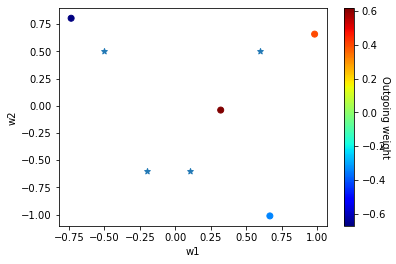

In [37]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(new_incoming_weights_x,
            new_incoming_weights_y,
            c = new_outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar().set_label('Outgoing weight',rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

# Train the model from this point

## Create new NN of size 4 after reduction of 1 neuron

In [38]:
w_in = torch.DoubleTensor([[new_incoming_weights_x[0], new_incoming_weights_y[0]],
                           [new_incoming_weights_x[1], new_incoming_weights_y[1]],
                           [new_incoming_weights_x[2], new_incoming_weights_y[2]],
                           [new_incoming_weights_x[3], new_incoming_weights_y[3]]])
w_out = torch.DoubleTensor([new_outgoing_weights])
dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in, w_out)

## End-to-end training helper method

In [39]:
from utils.training import train_first_order, train_second_order, perturbed_train_second_order

In [40]:
np.set_printoptions(precision=32)
# loss_vals, trace, final_weights = train(dummy_model, dataset, y_labels)
final_weights = train_second_order(dummy_model)
print(jax_loss(final_weights))
print(jnp.linalg.norm(jax_grad(final_weights)))

8.099134926152087e-05
3.2316566234225864e-11


In [41]:
perturbed_losses, perturbed_grads, perturbed_final_weights = perturbed_train_second_order(dummy_model)

In [42]:
perturbed_grads = np.array(perturbed_grads)
perturbed_losses = np.array(perturbed_losses)
perturbed_final_weights = np.array(perturbed_final_weights)
# perturbed_losses = perturbed_losses[perturbed_losses >= 1e-6]

Text(0, 0.5, 'Loss')

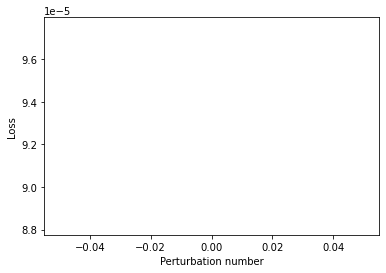

In [43]:
plt.plot(np.arange(0, len(perturbed_losses)), perturbed_losses)
plt.xlabel('Perturbation number')
plt.ylabel('Loss')

In [44]:
w_in_torch_format = torch.DoubleTensor(final_weights[0 : H_teacher * 2].reshape(H_teacher, 2))
w_out_torch_format = torch.DoubleTensor([final_weights[H_teacher * 2 :].reshape(H_teacher)])

# dummy_model = DummyNetwork(D_in, H_teacher, D_out,
#                            torch.DoubleTensor(trace[-1][0]),
#                            torch.DoubleTensor(trace[-1][1]))
# loss_val = nn.MSELoss()(dummy_model(dataset), y_labels)
# print('loss before second order opt.: ',loss_val.item())
# loss_grad = torch.autograd.grad(loss_val, dummy_model.parameters(), create_graph=True)
# gradients = loss_grad[0].reshape(H_teacher * 2).detach().numpy()
# gradients = np.append(gradients, loss_grad[1][0].detach().numpy())
# print('grad norm before second order opt.: ', np.linalg.norm(gradients))

dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in_torch_format, w_out_torch_format)
loss_val = nn.MSELoss()(dummy_model(torch.DoubleTensor(dataset)), torch.DoubleTensor(labels))
print('loss after second order opt.: ',loss_val.item())
loss_grad = torch.autograd.grad(loss_val, dummy_model.parameters(), create_graph=True)
gradients = loss_grad[0].reshape(H_teacher * 2).detach().numpy()
gradients = np.append(gradients, loss_grad[1][0].detach().numpy())
print('grad norm after second order opt.: ', np.linalg.norm(gradients))

loss after second order opt.:  8.09913492615209e-05
grad norm after second order opt.:  3.231656637530429e-11


# Replot the neuron points after training

In [45]:
total_outgoing_weights = np.concatenate([outgoing_weights, w_out_torch_format[0]], axis=0)
min_outgoing_weight, max_outgoing_weight = total_outgoing_weights.min(), total_outgoing_weights.max()

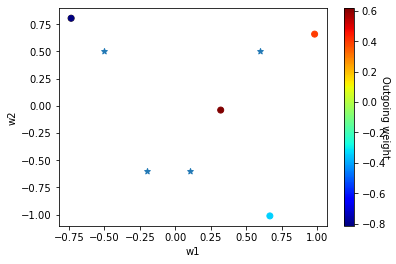

In [46]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

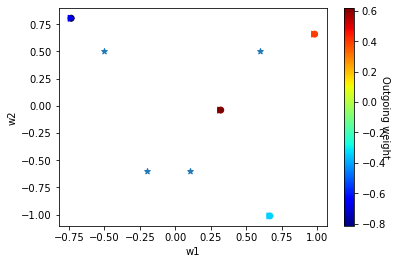

In [47]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

# plt.scatter(trace[-1][0][:, 0],
#             trace[-1][0][:, 1],
#             c = trace[-1][1][0],
#             cmap = matplotlib.cm.jet,
#             marker="+")

plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format[0],
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

In [48]:
local_min = np.array([incoming_weights_x[0], incoming_weights_y[0],
             incoming_weights_x[1], incoming_weights_y[1],
             incoming_weights_x[2], incoming_weights_y[2],
             incoming_weights_x[3], incoming_weights_y[3],
             incoming_weights_x[4], incoming_weights_y[4],
             outgoing_weights[0], outgoing_weights[1], outgoing_weights[2],
             outgoing_weights[3], outgoing_weights[4]])
print(local_min)

[ 0.3195520888581026   -0.039923840043947265 -0.7345505945267169
  0.8039611632286122    0.6661511292864194   -1.0126555858766897
  0.9814681204937439    0.6580154296957467   -0.7345489746807867
  0.8039597629685223    0.6155369494601918    0.1433407208654592
 -0.34013755116068917   0.39531142257453944  -0.8140491475825246  ]


# Find the SI saddle line and the optimal \mu

In [49]:
def construct_si_saddle(final_weights, mu):
    num_neurons = int(len(final_weights) / 3)
    w_in_torch_format = final_weights[0 : num_neurons * 2].reshape(num_neurons, 2)
    w_out_torch_format = final_weights[num_neurons * 2 :].reshape(num_neurons)

    si_saddle = np.array([])
    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1 or i == idx_neuron2:
        si_saddle = np.append(si_saddle, w_in_torch_format[0][0])
        si_saddle = np.append(si_saddle, w_in_torch_format[0][1])
        continue
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][0])
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][1])
      teacher_idx += 1

    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1:
        si_saddle = np.append(si_saddle,
                              mu * w_out_torch_format[0])
        continue
      if i == idx_neuron2:
        si_saddle = np.append(si_saddle,
                              (1 - mu) * w_out_torch_format[0])
        continue
      si_saddle = np.append(si_saddle,
                            w_out_torch_format[teacher_idx])
      teacher_idx += 1

    return si_saddle

In [50]:
def find_saddle_line(final_weights):
    saddle_smallest_u = construct_si_saddle(final_weights, -1)
    saddle_largest_u = construct_si_saddle(final_weights, 2)
    
    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    optimal_mu = closest_saddle[2 * H_student + idx_neuron1] / w_out_torch_format[0][0].item()
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, optimal_mu, directional_vector

In [51]:
closest_saddle, optimal_mu, directional_vector = find_saddle_line(final_weights)
print('Optimal mu:', optimal_mu)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Optimal mu: -0.2137154321269197
Distance to local min: 2.559139032667169e-06


0.48731574408856737


Text(0, 0.5, 'Distance to local min')

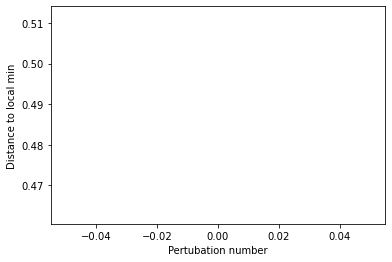

In [52]:
perturbed_distances_to_local_min = []

for perturbed_final_weights_sample in perturbed_final_weights:
    perturbed_closest_saddle, perturbed_optimal_mu, perturbed_directional_vector = find_saddle_line(perturbed_final_weights_sample)
    new_dist_min_saddle = np.linalg.norm(local_min - perturbed_closest_saddle)
    if new_dist_min_saddle < dist_min_saddle:
        dist_min_saddle = new_dist_min_saddle
        closest_saddle = perturbed_closest_saddle
        optimal_mu = perturbed_optimal_mu
        directional_vector = perturbed_directional_vector
    perturbed_distances_to_local_min.append(new_dist_min_saddle)
print(min(perturbed_distances_to_local_min))
plt.plot(np.arange(0, len(perturbed_distances_to_local_min)), perturbed_distances_to_local_min)
plt.xlabel('Pertubation number')
plt.ylabel('Distance to local min')

Text(0, 0.5, 'Distance (L2) to local min')

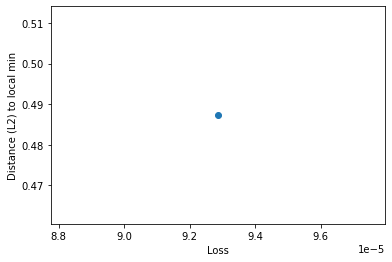

In [53]:
plt.scatter(perturbed_losses, perturbed_distances_to_local_min)
plt.xlabel('Loss')
# plt.xscale('log')
plt.ylabel('Distance (L2) to local min')

# Eigenspectrum of the closest SI saddle

[1.4555647134136164e-17 7.4307505501373810e-07 3.9821285395919832e-05
 5.6665753972391384e-05 1.7355689640981913e-04 2.8540938043479210e-04
 7.8794062825227995e-04 2.3459573821536070e-03 6.3792512200328347e-03
 9.9767072614994588e-03 4.1939338019932902e-02 8.2368467331196946e-02
 8.1935156476444471e-01 1.1974789526305434e+00 2.6374884181199230e+00]


Text(0, 0.5, 'Eigenvalue')

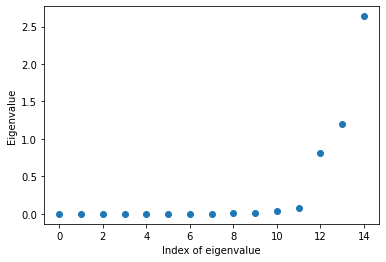

In [54]:
evals, _ = jax_evals(closest_saddle)
print(evals)
plt.scatter(np.arange(len(evals)), evals)
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue')

# Compute loss across the 1D line between local min and closest saddle

In [55]:
def get_losses_across_line(start_si_saddle, directional_vector, eps=1e-4):
    line_point = start_si_saddle
    distances_to_saddle = [0]
    losses_to_min = [jax_loss(start_si_saddle)]

    while True:
      line_point = line_point + eps * directional_vector

      loss_val = jax_loss(line_point)
      distances_to_saddle.append(np.linalg.norm(start_si_saddle - line_point))
      losses_to_min.append(loss_val)

      if np.linalg.norm(line_point - start_si_saddle) >= 2 * np.linalg.norm(local_min - start_si_saddle):
        break
    return distances_to_saddle, losses_to_min

In [56]:
distances_to_saddle, losses_to_min = get_losses_across_line(closest_saddle, directional_vector)

8.099134926153118e-05
8.099134926151902e-05


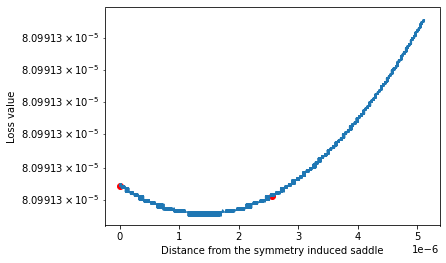

In [57]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
print(min(losses_to_min))

plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')

# Compute loss across the 1D line for a range of \mu

[1.0094004439167268e-16 1.9858983423339182e-06]
[-1.1420419221213376e-16  1.9976699832148126e-06]
[4.4098624121317943e-17 2.0082123171994993e-06]
[-1.7040755035147494e-16  2.0176890761312354e-06]
[9.162870328974581e-17 2.026237872354705e-06]
[-1.8353091788157609e-16  2.0339749994486483e-06]
[-1.4420530390290810e-16  2.0409992378992217e-06]
[-1.9241302329933306e-16  2.0473949024973930e-06]
[4.2378118903990996e-17 2.0532342921833635e-06]
[-1.1986918676581902e-16  2.0585796740975213e-06]


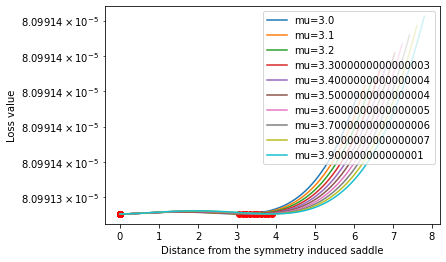

In [58]:
# mu_range = [0, 0.25, 0.5, 0.75, 1, 2, 5, 10]
mu_range = np.arange(3, 4, 0.1)
# mu_range = [-2.2, -2.1, -1.9, -1.8, -1.7, -1.6, -1.5]
# fig_escape, axs = plt.subplots(len(mu_range), 1)
# fig_escape.set_size_inches(5, 30)

for idx, mu in enumerate(mu_range):
    si_saddle = construct_si_saddle(final_weights, mu)
    directional_vector = local_min - si_saddle
    distances_to_saddle, losses_to_min = get_losses_across_line(si_saddle, directional_vector)
    plt.plot(distances_to_saddle, losses_to_min, label="mu=" + str(mu))
    
    # Mark the position of the closest saddle in the chart.
    plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
    plt.yscale('log')

    # Mark the position of the local min in the chart.
    local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - si_saddle)))
    plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')
    plt.xlabel('Distance from the symmetry induced saddle')
    plt.ylabel('Loss value')

    evals, _ = jax_evals(si_saddle)
    print(evals[:2])

plt.legend(loc="upper right")

# Compute the 2D plane between the SI saddles line and the local min

In [59]:
left_saddle_limit = deepcopy(closest_saddle)
right_saddle_limit = deepcopy(closest_saddle)
print('loss at left saddle limit:', jax_loss(left_saddle_limit))
print('loss at right saddle limit:', jax_loss(right_saddle_limit))
print('loss at closest saddle:', jax_loss(closest_saddle))
print('loss at local min:', jax_loss(local_min))

saddle_line_size = 10
left_saddle_limit[2 * H_student + idx_neuron1] += -saddle_line_size / 2
left_saddle_limit[2 * H_student + idx_neuron2] += saddle_line_size / 2

right_saddle_limit[2 * H_student + idx_neuron1] += saddle_line_size / 2
right_saddle_limit[2 * H_student + idx_neuron2] += -saddle_line_size / 2

loss at left saddle limit: 8.099134926152088e-05
loss at right saddle limit: 8.099134926152088e-05
loss at closest saddle: 8.099134926152088e-05
loss at local min: 8.09913492615202e-05


In [60]:
x_dist = np.linalg.norm(right_saddle_limit - left_saddle_limit)
y_dist = np.linalg.norm(closest_saddle - local_min)

direction_x_axis = (right_saddle_limit - left_saddle_limit) / np.linalg.norm(right_saddle_limit - left_saddle_limit)
direction_y_axis = (local_min - closest_saddle) / np.linalg.norm(local_min - closest_saddle)

num_steps_x_axis = 300
step_x_axis = x_dist / num_steps_x_axis
offset_oy = 70
num_steps_y_axis = 300 - 2 * offset_oy
step_y_axis = y_dist / num_steps_y_axis

left_saddle_limit = left_saddle_limit - offset_oy * step_y_axis * direction_y_axis
right_saddle_limit = right_saddle_limit - offset_oy * step_y_axis * direction_y_axis

y_dist = np.linalg.norm(closest_saddle - offset_oy * step_y_axis * direction_y_axis - \
                        local_min - offset_oy * step_y_axis * direction_y_axis)
num_steps_y_axis = 300

x_axis_points = []
y_axis_points= []

for num_step in range(num_steps_x_axis + 1):
  x_axis_points.append(num_step * step_x_axis * direction_x_axis)

for num_step in range(num_steps_y_axis + 1):
  y_axis_points.append(num_step * step_y_axis * direction_y_axis)


print(len(x_axis_points))

loss_values = []
neuron_points = [left_saddle_limit + x_axis_point + y_axis_point for y_axis_point in y_axis_points for x_axis_point in x_axis_points]

for y_axis_point in y_axis_points:
  for x_axis_point in x_axis_points:
    neuron_point = left_saddle_limit + x_axis_point + y_axis_point
    loss_val = jax_loss(neuron_point)

    loss_values.append(np.log(loss_val))

301


In [61]:
def find_projection_on_plane(neuron_point, plane_neuron_points):
  min_dist = np.inf
  row_idx = None
  col_idx = None

  for idx, plane_neuron_point in enumerate(plane_neuron_points):
    if np.linalg.norm(neuron_point - plane_neuron_point) < min_dist:
      min_dist = np.linalg.norm(neuron_point - plane_neuron_point)
      row_idx = int(idx / (num_steps_x_axis + 1))
      col_idx = idx % (num_steps_x_axis + 1)
  
  return row_idx, col_idx

def fetch_trajectories_as_neuron_points(data_row):
  traj_neuron_points = []

  for i in range(0, int(data_row['student size'])):
    neuron_traj_x = np.fromstring(data_row['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_row['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    if len(traj_neuron_points) == 0:
      for j in range(0, len(neuron_traj_x)):
        traj_neuron_points.append([])

    for idx, _ in enumerate(neuron_traj_x):
      traj_neuron_points[idx].append(neuron_traj_x[idx])
      traj_neuron_points[idx].append(neuron_traj_y[idx])

  for i in range(0, int(data_row['student size'])):
    neuron_a = np.fromstring(data_row['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    for idx, _ in enumerate(neuron_a):
      traj_neuron_points[idx].append(neuron_a[idx])
    
  return traj_neuron_points

def plot_projected_trajectories(data_row):
  traj_neuron_points = fetch_trajectories_as_neuron_points(data_row)

  projected_points_row = []
  projected_points_col = []
  # Necessarily include the first point.
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[0], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)

  for idx, traj_neuron_point in enumerate(traj_neuron_points):
    if idx >= len(traj_neuron_points) - 2:
      break
    if idx % 5 == 0:
      row_idx, col_idx = find_projection_on_plane(traj_neuron_point, neuron_points)
      projected_points_row.append(row_idx)
      projected_points_col.append(col_idx)

  # Include the second to last point (Adam last point).
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[-2], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)
  plt.scatter([col_idx], [row_idx], marker='+', color='red')
  print(row_idx, col_idx)


  # Necessarily include the last point.
  row_idx, col_idx = find_projection_on_plane(traj_neuron_points[-1], neuron_points)
  projected_points_row.append(row_idx)
  projected_points_col.append(col_idx)
  print(row_idx, col_idx)

  plt.plot(projected_points_col, projected_points_row, color='red')
  plt.scatter(projected_points_col[0], projected_points_row[0],
              marker='*', color='red')
  plt.scatter(projected_points_col[-1], projected_points_row[-1],
              marker='*', color='red')

234 150
230 150


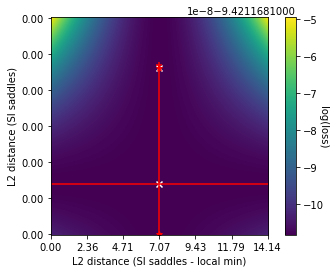

In [62]:
closest_saddle_ox_coord = int (num_steps_x_axis / 2)
closest_saddle_oy_coord = offset_oy

local_min_ox_coord = closest_saddle_ox_coord
local_min_oy_coord = num_steps_y_axis - offset_oy

np_loss_values = np.array(loss_values).reshape(num_steps_y_axis + 1,
                                               num_steps_x_axis + 1)

fig_2dplane, ax = plt.subplots(1, 1)

ticks_oy = np.linspace(0, num_steps_y_axis, 7)
ticks_ox = np.linspace(0, num_steps_x_axis, 7)

ticklabels_ox = ["{:.2f}".format(np.linalg.norm(neuron_points[int(i)] - neuron_points[0])) for i in ticks_ox]
ticklabels_oy = ["{:.2f}".format(np.linalg.norm(neuron_points[(num_steps_x_axis + 1) * int(i)] - neuron_points[0])) for i in ticks_oy]

grid_img = ax.imshow(np_loss_values, interpolation='bilinear', origin = 'lower')
ax.set_xticks(ticks_ox)
ax.set_xticklabels(ticklabels_ox)
ax.set_yticks(ticks_oy)
ax.set_yticklabels(ticklabels_oy)

ax.scatter([closest_saddle_ox_coord, local_min_ox_coord],
           [closest_saddle_oy_coord, local_min_oy_coord],
           marker='x', color='white')

ax.plot([0, num_steps_x_axis],
        [closest_saddle_oy_coord, closest_saddle_oy_coord], color='red')


fig_2dplane.colorbar(grid_img).set_label('log(loss)',rotation=270)
# fig_2dplane.suptitle('Loss(log) on the plane formed by local min the SI saddles')

plot_projected_trajectories(sample_point)
plt.xlabel('L2 distance (SI saddles - local min)')
plt.ylabel('L2 distance (SI saddles)')

plt.show()

Text(0, 0.5, 'L2 norm between 2 neurons')

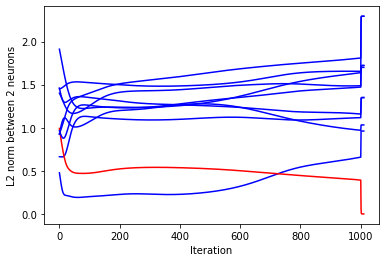

In [63]:
traj_neuron_points = fetch_trajectories_as_neuron_points(sample_point)
traj_neuron_points = np.array(traj_neuron_points)
for i in range(H_student):
    for j in range(i + 1, H_student):
        traj_neuron_i = traj_neuron_points[:, 2 * i : 2 * i + 2]

        traj_neuron_j = traj_neuron_points[:, 2 * j : 2 * j + 2]
        
        inter_neuron_distances = np.sqrt(((traj_neuron_i - traj_neuron_j) ** 2).sum(axis=-1))
        color = 'blue'
        if i == idx_neuron1 and j == idx_neuron2:
            color = 'red'
        plt.plot(np.arange(0, len(inter_neuron_distances)), inter_neuron_distances, color=color)

plt.xlabel('Iteration')
plt.ylabel('L2 norm between 2 neurons')

# Finding the SI saddle directly from the local min

## Using second order optimization

In [64]:
from utils.training import regularized_second_order_train
%load_ext autoreload
%autoreload 2

In [65]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
w_out = np.array([outgoing_weights], dtype=np.float64)
weights = np.append(w_in.reshape(H_student * 2),
                    w_out.reshape(H_student))

In [66]:
final_weights = regularized_second_order_train(weights)
print('Gradient at this point:', jnp.linalg.norm(jax_grad(final_weights)))
w_in_torch_format = final_weights[0 : 2 * H_student].reshape(H_student, 2)
w_out_torch_format = final_weights[2 * H_student : ].reshape(H_student)

Gradient at this point: 0.45961782516276095


Text(0, 0.5, 'w2')

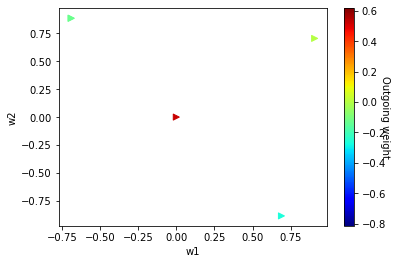

In [67]:
plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format,
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

In [68]:
def find_saddle_line_from_reg_saddle(final_weights):
    saddle_smallest_u = deepcopy(final_weights)
    saddle_smallest_u[2 * H_student + idx_neuron1] -= 1
    saddle_smallest_u[2 * H_student + idx_neuron2] += 1

    saddle_largest_u = deepcopy(final_weights)

    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, directional_vector

In [69]:
closest_saddle, directional_vector = find_saddle_line_from_reg_saddle(final_weights)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Distance to local min: 0.6318197886219646


In [70]:
line_point = closest_saddle
distances_to_saddle = [0]
losses_to_min = [jax_loss(closest_saddle)]

print(jax_loss(line_point))

while True:
  eps = 1e-4
  line_point = line_point + eps * directional_vector

  loss_val = jax_loss(line_point)
  distances_to_saddle.append(np.linalg.norm(closest_saddle - line_point))
  losses_to_min.append(loss_val)

  if np.linalg.norm(line_point - closest_saddle) >= 1 + np.linalg.norm(local_min - closest_saddle):
    break

0.12914764490674738


0.35368462388254673


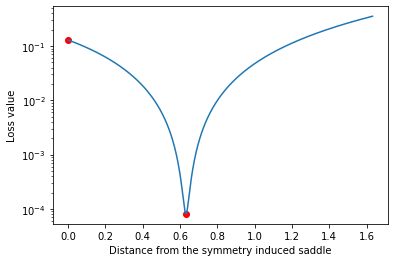

In [71]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')

## Using first order optimization

In [72]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
w_out = np.array([outgoing_weights], dtype=np.float64)
weights = np.append(w_in.reshape(H_student * 2),
                    w_out.reshape(H_student))

In [73]:
def pytorch_regularized_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

def regularized_first_order_train(model, x, y_labels,  N = 10, Ninner = 10 ** 3, Nstart = 10):
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
  psi = 1

  loss_vals = []

  for i in range(1, N + 1):
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)

      model_params = []
      for param in model.parameters():
        model_params.append(param)
      model_params_w_in = model_params[0]
      model_params_w_out = model_params[1]
      
      neuron1 = torch.cat((model_params_w_in[idx_neuron1, :], model_params_w_out[:, idx_neuron1]), dim=-1)
      neuron2 = torch.cat((model_params_w_in[idx_neuron2, :], model_params_w_out[:, idx_neuron2]), dim=-1)
      # neuron1 = model_params_w_in[idx_neuron1, :]
      # neuron2 = model_params_w_in[idx_neuron2, :]
      # print(neuron1, neuron2)
      
      loss = pytorch_regularized_loss(y, y_labels) + psi * torch.norm(neuron1 - neuron2)
    
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)

      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart  : j]))

    loss_vals.append(np.mean(loss_tmp))
    
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    # print(g_vector)
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    
#   final_weights = train_second_order(model)
#   final_weights = regularized_second_order_train(jnp.append(
#                       deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
#                       deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student))))
#   return final_weights
  return np.append(deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
                     deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student)))


In [74]:
dummy_model = DummyNetwork(D_in, H_student, D_out, torch.DoubleTensor(w_in), torch.DoubleTensor(w_out))

In [75]:
final_weights = regularized_first_order_train(dummy_model, torch.DoubleTensor(dataset),
                                              torch.DoubleTensor(labels))

Iteration: 1000, loss: 0.23022934846855864, gradient norm: tensor(1.4142)
Iteration: 2000, loss: 0.0010809913492718605, gradient norm: tensor(1.4142)
Iteration: 3000, loss: 0.0010809913492706897, gradient norm: tensor(1.4142)
Iteration: 4000, loss: 0.0010809913492701385, gradient norm: tensor(1.4142)
Iteration: 5000, loss: 0.0010809913492697122, gradient norm: tensor(1.4142)
Iteration: 6000, loss: 0.00108099134926933, gradient norm: tensor(1.4142)
Iteration: 7000, loss: 0.001080991349268976, gradient norm: tensor(1.4142)
Iteration: 8000, loss: 0.0010809913492686452, gradient norm: tensor(1.4142)
Iteration: 9000, loss: 0.0010809913492683342, gradient norm: tensor(1.4142)
Iteration: 10000, loss: 0.0010809913492680434, gradient norm: tensor(1.4142)


In [76]:
print(final_weights)
print('Gradient at this point:', jnp.linalg.norm(jax_grad(final_weights)))
w_in_torch_format = final_weights[0 : 2 * H_student].reshape(H_student, 2)
w_out_torch_format = final_weights[2 * H_student : ].reshape(H_student)

[ 0.3195520765528138  -0.03992386948383459 -0.7345496984878737
  0.8039604657029311   0.6661512456920103  -1.0126555536360058
  0.9814681677851627   0.6580153830654962  -0.7345496965632194
  0.8039604636744825   0.615536925224374   -0.3346592029948433
 -0.34013765164398224  0.39531140165305023 -0.3360490714452381 ]
Gradient at this point: 1.6533553630207148e-08


### Eigenspectrum of the closest SI saddle

[-1.4570617848354278e-04 -2.1864529786127538e-06  1.1045354621496837e-10
  4.1213957209146446e-05  1.1414474937578482e-04  2.6636320034421115e-04
  7.1601976449181689e-04  1.7495928580740163e-03  6.2290380900175881e-03
  7.5190956210076411e-03  3.5025694761353893e-02  5.1040908538065949e-02
  6.2056894009083918e-01  1.1895425393851098e+00  2.6286193930059607e+00]


Text(0, 0.5, 'Eigenvalue')

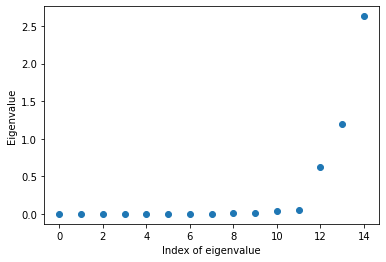

In [77]:
evals, _ = jax_evals(final_weights)
print(evals)
plt.scatter(np.arange(len(evals)), evals)
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue')

Text(0, 0.5, 'w2')

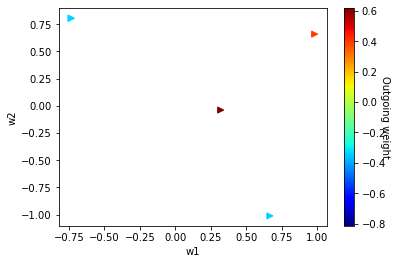

In [78]:
plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format,
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

### Plotting the 1D distance to the local min

In [79]:
closest_saddle, directional_vector = find_saddle_line_from_reg_saddle(final_weights)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Distance to local min: 1.5310994736605535e-06


In [80]:
line_point = closest_saddle
distances_to_saddle = [0]
losses_to_min = [jax_loss(closest_saddle)]

print(jax_loss(line_point))

while True:
  eps = 1e-4
  line_point = line_point + eps * directional_vector

  loss_val = jax_loss(line_point)
  distances_to_saddle.append(np.linalg.norm(closest_saddle - line_point))
  losses_to_min.append(loss_val)

  if np.linalg.norm(line_point - closest_saddle) >= 2 * np.linalg.norm(local_min - closest_saddle):
    break

8.099134926788436e-05


8.099134926788436e-05


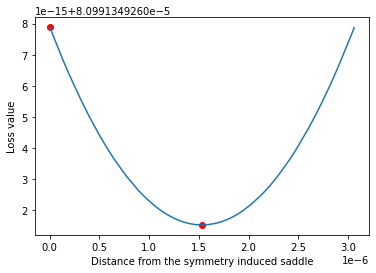

In [81]:
plt.plot(distances_to_saddle, losses_to_min)
print(max(losses_to_min))
plt.xlabel('Distance from the symmetry induced saddle')
plt.ylabel('Loss value')

# Mark the position of the closest saddle in the chart.
plt.scatter(distances_to_saddle[0], losses_to_min[0], color='red')
# plt.yscale('log')

# Mark the position of the local min in the chart.
local_min_idx = np.argmin(abs(distances_to_saddle - np.linalg.norm(local_min - closest_saddle)))
plt.scatter(distances_to_saddle[local_min_idx], losses_to_min[local_min_idx], color='red')

### Reapply our own algorithm from this point

In [82]:
min_dist = np.inf
idx_neuron1 = None
idx_neuron2 = None

incoming_weights = final_weights[0: 2 * H_student].reshape(H_student, 2)
incoming_weights_x = incoming_weights[:, 0]
incoming_weights_y = incoming_weights[:, 1]
outgoing_weights = final_weights[2 * H_student:]

for i in range(H_student):
  current_neuron = np.array([incoming_weights_x[i], incoming_weights_y[i]])
  for j in range(i + 1, H_student):
    potential_closest_neuron = np.array([incoming_weights_x[j], incoming_weights_y[j]])
    if min_dist > np.linalg.norm(current_neuron - potential_closest_neuron):
      min_dist = np.linalg.norm(current_neuron - potential_closest_neuron)
      idx_neuron1 = i
      idx_neuron2 = j
    
new_incoming_weights_x = [(incoming_weights_x[idx_neuron1] + incoming_weights_x[idx_neuron2]) / 2.0]
new_incoming_weights_y = [(incoming_weights_y[idx_neuron1] + incoming_weights_y[idx_neuron2]) / 2.0]
new_outgoing_weights = [(outgoing_weights[idx_neuron1] + outgoing_weights[idx_neuron2])]


for i in range(H_student):
  if i == idx_neuron1 or i == idx_neuron2:
    continue
  new_incoming_weights_x.append(incoming_weights_x[i])
  new_incoming_weights_y.append(incoming_weights_y[i])
  new_outgoing_weights.append(outgoing_weights[i])

print(final_weights)
print(new_incoming_weights_x, new_incoming_weights_y, new_outgoing_weights)


[ 0.3195520765528138  -0.03992386948383459 -0.7345496984878737
  0.8039604657029311   0.6661512456920103  -1.0126555536360058
  0.9814681677851627   0.6580153830654962  -0.7345496965632194
  0.8039604636744825   0.615536925224374   -0.3346592029948433
 -0.34013765164398224  0.39531140165305023 -0.3360490714452381 ]
[-0.7345496975255466, 0.3195520765528138, 0.6661512456920103, 0.9814681677851627] [0.8039604646887069, -0.03992386948383459, -1.0126555536360058, 0.6580153830654962] [-0.6707082744400814, 0.615536925224374, -0.34013765164398224, 0.39531140165305023]


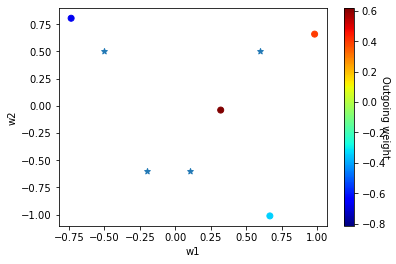

In [83]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(new_incoming_weights_x,
            new_incoming_weights_y,
            c = new_outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

In [84]:
w_in = torch.DoubleTensor([[new_incoming_weights_x[0], new_incoming_weights_y[0]],
                           [new_incoming_weights_x[1], new_incoming_weights_y[1]],
                           [new_incoming_weights_x[2], new_incoming_weights_y[2]],
                           [new_incoming_weights_x[3], new_incoming_weights_y[3]]])
w_out = torch.DoubleTensor([new_outgoing_weights])
dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in, w_out)

In [85]:
final_weights = train_second_order(dummy_model)
print(jax_loss(final_weights))
print(jnp.linalg.norm(jax_grad(final_weights)))

w_in_torch_format = torch.DoubleTensor(final_weights[: H_teacher * 2].reshape(H_teacher, 2))
w_out_torch_format = torch.DoubleTensor([final_weights[H_teacher * 2 :].reshape(H_teacher)])

8.099134926152103e-05
3.305059302480889e-11


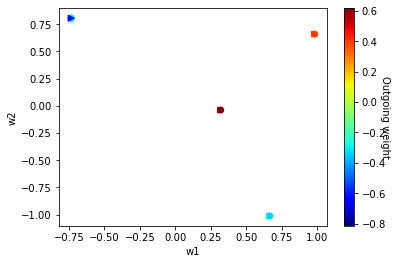

In [86]:
plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format[0],
            cmap = matplotlib.cm.jet,
            marker=">")
plt.clim(min_outgoing_weight, max_outgoing_weight)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

In [87]:
closest_saddle, optimal_mu, directional_vector = find_saddle_line(final_weights)
print('Optimal mu:', optimal_mu)
print('Distance to local min:', np.linalg.norm(local_min - closest_saddle))

dist_min_saddle = np.linalg.norm(local_min - closest_saddle)

Optimal mu: -0.21371543324728143
Distance to local min: 2.5577816379835756e-06


In [88]:
from utils.utils import TheoremChecker
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
%autoreload 2
D_in, H_teacher, D_out = 2, 4, 1
theorem_checker = TheoremChecker(D_in, H_teacher, D_out)

In [90]:
Y, U = theorem_checker.check_si_saddle_failure_mode(final_weights)

print(Y)
evals, _ = jnp.linalg.eig(Y)
print(evals)

[[-6.407870389784890e-05 -7.106868089442558e-05]
 [-7.106868089442560e-05 -8.378599873193362e-05]]
[-2.1838198212566467e-06+0.j -1.4568088280852588e-04+0.j]
